In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=90, 
                                    vertical_flip=True,validation_split=0.17
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Puneeth/Major/new_dataset/new1/Train',
                                                 target_size = (512,512),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 subset='training',
                                                 shuffle=True)
val_generator = train_datagen.flow_from_directory(
   '/content/drive/MyDrive/Puneeth/Major/new_dataset/new1/Train',
   target_size = (512,512),
    subset='validation',
    batch_size = 16,
    class_mode = 'categorical',
    shuffle=True
)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Puneeth/Major/new_dataset/new1/Test',
                                            target_size = (512,512),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            
                                            shuffle=False)

Found 2705 images belonging to 4 classes.
Found 553 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


In [ ]:
c = ResNet50(input_tensor=Input(shape=(512,512,3)))
c.summary()

102973440/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
c.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
for layer in c.layers:
    layer.trainable = False

In [ ]:
head = c.layers[-2].output
head = Flatten(name='Flatten')(head)
head = Dense(512, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(512, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(512, activation='relu')(head)
head = Dropout(0.2)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(4, activation='softmax')(head)

m = Model(c.input, head)
opt = SGD(learning_rate=3e-4,momentum=0.9)
m.compile(loss = 'categorical_crossentropy', 
              optimizer=opt, 
              metrics= ["accuracy"]
             )
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

In [ ]:
k=m.fit(training_set,epochs = 20,validation_data= val_generator,callbacks=[checkpointer, earlystopping])

Epoch 1/20
170/170 [==============================] - 970s 5s/step - loss: 1.3133 - accuracy: 0.3830 - val_loss: 1.5253 - val_accuracy: 0.3363

Epoch 00001: val_loss improved from inf to 1.52532, saving model to clf-resnet-weights.hdf5
Epoch 2/20
170/170 [==============================] - 254s 1s/step - loss: 0.6417 - accuracy: 0.7680 - val_loss: 1.6763 - val_accuracy: 0.4286

Epoch 00002: val_loss did not improve from 1.52532
Epoch 3/20
170/170 [==============================] - 253s 1s/step - loss: 0.3710 - accuracy: 0.8547 - val_loss: 1.5475 - val_accuracy: 0.3725

Epoch 00003: val_loss did not improve from 1.52532
Epoch 4/20
170/170 [==============================] - 248s 1s/step - loss: 0.2908 - accuracy: 0.8815 - val_loss: 2.6833 - val_accuracy: 0.3725

Epoch 00004: val_loss did not improve from 1.52532
Epoch 5/20
170/170 [==============================] - 249s 1s/step - loss: 0.2655 - accuracy: 0.8976 - val_loss: 1.8106 - val_accuracy: 0.4105

Epoch 00005: val_loss did not impro

In [ ]:
_, acc = m.evaluate(test_set)
print("Test accuracy : {} %".format(acc*100))

36/36 [==============================] - 133s 4s/step - loss: 0.3199 - accuracy: 0.9045
Test accuracy : 90.45138955116272 %


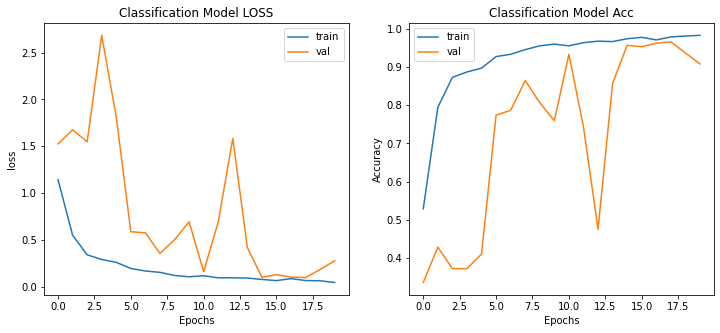

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k.history['loss']);
plt.plot(k.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(k.history['accuracy']);
plt.plot(k.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
prediction = m.predict(test_set)

In [ ]:
import numpy as np
pred = np.argmax(prediction, axis=1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
y_true = test_set.classes

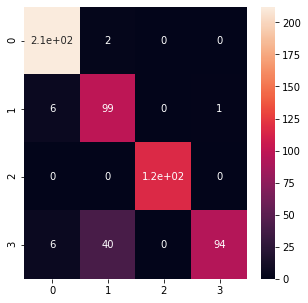

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

In [ ]:
# saving model achitecture in json file
model_json = m.to_json()
with open("resnet50try.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
report = classification_report(y_true, pred, labels = [0,1,2,3])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       214
           1       0.70      0.93      0.80       106
           2       1.00      1.00      1.00       116
           3       0.99      0.67      0.80       140

    accuracy                           0.90       576
   macro avg       0.91      0.90      0.89       576
weighted avg       0.92      0.90      0.90       576



In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import *

In [ ]:
json_file = open('/content/resnet50try.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/clf-resnet-weights.hdf5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
_, acc = loaded_model.evaluate(test_set)
print("Test accuracy : {} %".format(acc*100))

36/36 [==============================] - 11s 269ms/step - loss: 0.0754 - accuracy: 0.9816
Test accuracy : 95.48611044883728 %


In [ ]:
prediction = loaded_model.predict(test_set)

In [ ]:
import numpy as np
pred = np.argmax(prediction, axis=1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,

In [ ]:
y_true = test_set.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

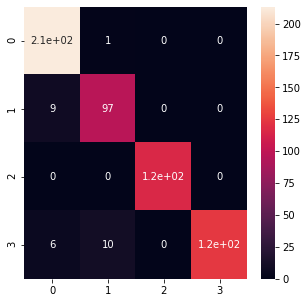

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

In [ ]:
true=[]
for i in y_true:
  if(i==0):
    true.append('glioma')
  elif(i==1):
    true.append('meningioma')
  elif(i==2):
    true.append('notumor')
  elif(i==3):
    true.append('pituitary')
true


In [ ]:
predicted=[]
for i in pred:
  if(i==0):
    predicted.append('glioma')
  elif(i==1):
    predicted.append('meningioma')
  elif(i==2):
    predicted.append('notumor')
  elif(i==3):
    predicted.append('pituitary')


In [ ]:
labels = ['glioma', 'meningioma','notumor', 'pituitary']

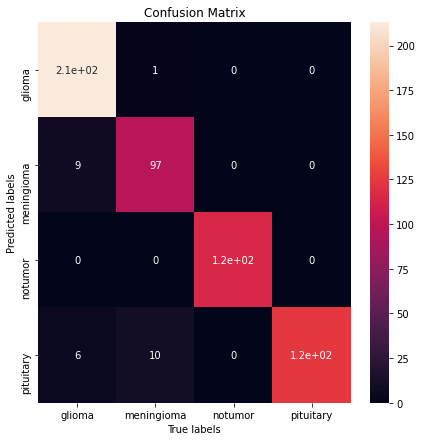

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(true, predicted,labels)
plt.figure(figsize = (7,7))
ax= plt.subplot()
sns.heatmap(cm, annot=True,ax=ax)
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['glioma', 'meningioma','notumor', 'pituitary']); ax.yaxis.set_ticklabels(['glioma', 'meningioma','notumor', 'pituitary']);

In [ ]:
report = classification_report(y_true, pred, labels = [0,1,2,3])
print(report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       214
           1       0.90      0.92      0.91       106
           2       1.00      1.00      1.00       116
           3       1.00      0.89      0.94       140

    accuracy                           0.95       576
   macro avg       0.96      0.95      0.95       576
weighted avg       0.96      0.95      0.95       576



In [ ]:
report = classification_report(true, predicted)
print(report)

              precision    recall  f1-score   support

      glioma       0.93      1.00      0.96       214
  meningioma       0.90      0.92      0.91       106
     notumor       1.00      1.00      1.00       116
   pituitary       1.00      0.89      0.94       140

    accuracy                           0.95       576
   macro avg       0.96      0.95      0.95       576
weighted avg       0.96      0.95      0.95       576



In [ ]:
import shutil
shutil.copy('/content/clf-resnet-weights.hdf5','/content/drive/MyDrive/Puneeth/Major/new_dataset/new/major_resnet50')

'/content/drive/MyDrive/Puneeth/Major/new_dataset/new/major_resnet50/clf-resnet-weights.hdf5'

In [ ]:
json_file = open('/content/drive/MyDrive/Puneeth/Major/new_dataset/new/major_resnet50/resnet50try.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Puneeth/Major/new_dataset/new/major_resnet50/clf-resnet-weights.hdf5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(512, 512))
  x = image.img_to_array(img)
  x=x/255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = loaded_model.predict(images, batch_size=10)
  print(classes[0])
  if(classes[0][0]>0.5):
    print('glioma')
  elif(classes[0][1]>0.5):
    print('meningioma')
  elif(classes[0][2]>0.5):
    print('no tumor')
  elif(classes[0][3]>0.5):
    print('pituitary')
  
 

Saving 714.png to 714 (2).png
Saving 3095.png to 3095 (1).png
Saving 8.png to 8 (2).png
Saving 725.png to 725 (3).png
[3.2844377e-04 8.9239713e-04 3.7916514e-04 9.9840003e-01]
pituitary
[4.5613723e-07 8.6275762e-08 9.9999940e-01 1.0625462e-08]
no tumor
[0.01018651 0.52301985 0.00417285 0.46262082]
meningioma
[9.7748804e-01 1.7320845e-02 8.6442451e-04 4.3267566e-03]
glioma


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Puneeth/Major/new_dataset/new1/Test',
                                            target_size = (512,512),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            
                                            shuffle=True)

Found 576 images belonging to 4 classes.


In [ ]:
_, acc = loaded_model.evaluate(test_set)
print("Test accuracy : {} %".format(acc*100))

36/36 [==============================] - 333s 9s/step - loss: 0.1544 - accuracy: 0.9613
Test accuracy : 95.48611044883728 %
